In [19]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [20]:
df = pd.read_csv('kaggle/input/spaceship-titanic/train.csv')

# for the sake of looking at the data, let's drop the rows with empty column values (we can look at imputing later if needed)
df = df.dropna()
df.isna().sum()


PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

## Analyze the data
**for this we will drop duplicates to get a cleaner view**

In [21]:
X = df.copy()

y = X.pop('Transported') 

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
    
discrete_features = X.dtypes == int

print(X.dtypes) 

PassengerId       int64
HomePlanet        int64
CryoSleep         int64
Cabin             int64
Destination       int64
Age             float64
VIP               int64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name              int64
dtype: object


**Mutual Information**

Scikit-learn has two mutual information metrics in its feature_selection module: one for real-valued targets (mutual_info_regression) and one for categorical targets (mutual_info_classif).

In [22]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]

PassengerId    0.693121
CryoSleep      0.113526
VRDeck         0.059783
HomePlanet     0.019240
VIP            0.000902
Name: MI Scores, dtype: float64

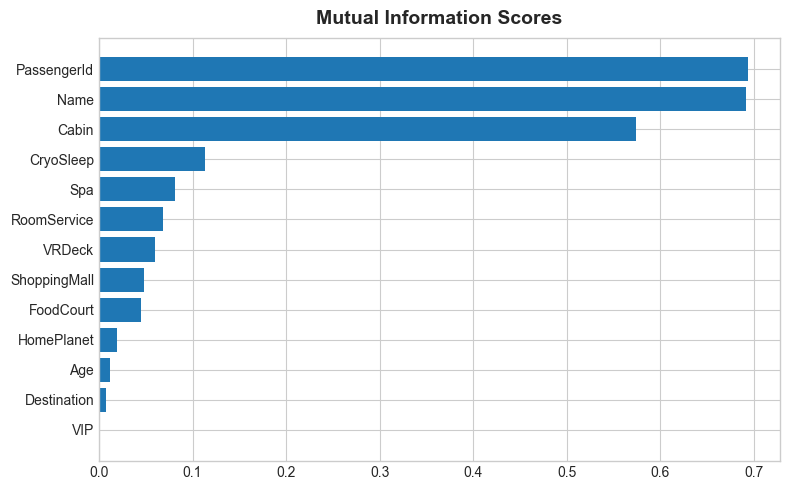

In [23]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

## Feature Engineering

PassengerID, Cabin, and Name all have values we can break apart to get more details

In [24]:

feat_X = df.copy()
feat_X.dropna()

feat_X[['Group', 'Member']] = feat_X['PassengerId'].str.split('_', expand=True)
feat_X['TotalGroupSize'] = feat_X.groupby('Group')['PassengerId'].transform('size')

feat_X[['FirstName', 'LastName']] = feat_X['Name'].str.split(' ', expand=True)

feat_X[['Deck', 'RoomNumber', 'Side']] = feat_X['Cabin'].str.split('/', expand=True)

feat_X['TotalSpent'] = feat_X['RoomService'] + feat_X['FoodCourt'] + feat_X['ShoppingMall'] + feat_X['Spa'] + feat_X['VRDeck']
feat_X['AverageSpentByHomePlanet'] = feat_X.groupby('HomePlanet')['TotalSpent'].transform('mean')
feat_X['AverageSpentByGroup'] = feat_X.groupby('Group')['TotalSpent'].transform('mean')
feat_X['TotalAmentitiesUsed'] = feat_X[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].gt(0).sum(axis=1)

feat_X['AverageAgeByGroup'] = feat_X.groupby('Group')['Age'].transform('mean')

feat_y = feat_X['Transported']

# Label encoding for categoricals
for colname in feat_X.select_dtypes("object"):
    feat_X[colname], _ = feat_X[colname].factorize()
    
discrete_features = feat_X.dtypes == int
discrete_features

X_impute = feat_X
y_impute = feat_y

feat_X.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,FirstName,LastName,Deck,RoomNumber,Side,TotalSpent,AverageSpentByHomePlanet,AverageSpentByGroup,TotalAmentitiesUsed,AverageAgeByGroup
0,0,0,0,0,0,39.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,3543.302451,0.0,0,39.0
1,1,1,0,1,0,24.0,0,109.0,9.0,25.0,...,1,1,1,0,1,736.0,691.678632,736.0,5,24.0
2,2,0,0,2,0,58.0,1,43.0,3576.0,0.0,...,2,2,2,0,1,10383.0,3543.302451,7779.5,4,45.5
3,3,0,0,2,0,33.0,0,0.0,1283.0,371.0,...,3,2,2,0,1,5176.0,3543.302451,7779.5,4,45.5
4,4,1,0,3,0,16.0,0,303.0,70.0,151.0,...,4,3,1,1,1,1091.0,691.678632,1091.0,5,16.0


**Cluster with k-Means**

In [25]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_feat_X = feat_X.copy()
scaled_feat_X = scaled_feat_X.drop(['Transported'], axis=1)
scaled_feat_X = scaler.fit_transform(scaled_feat_X)

kmeans = KMeans(n_clusters=5)
feat_X['Cluster'] = kmeans.fit_predict(scaled_feat_X)
feat_X['Cluster'] = feat_X['Cluster'].astype('category')

scaled_feat_X = feat_X.copy()

feat_X.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,LastName,Deck,RoomNumber,Side,TotalSpent,AverageSpentByHomePlanet,AverageSpentByGroup,TotalAmentitiesUsed,AverageAgeByGroup,Cluster
0,0,0,0,0,0,39.0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,3543.302451,0.0,0,39.0,0
1,1,1,0,1,0,24.0,0,109.0,9.0,25.0,...,1,1,0,1,736.0,691.678632,736.0,5,24.0,0
2,2,0,0,2,0,58.0,1,43.0,3576.0,0.0,...,2,2,0,1,10383.0,3543.302451,7779.5,4,45.5,4
3,3,0,0,2,0,33.0,0,0.0,1283.0,371.0,...,2,2,0,1,5176.0,3543.302451,7779.5,4,45.5,4
4,4,1,0,3,0,16.0,0,303.0,70.0,151.0,...,3,1,1,1,1091.0,691.678632,1091.0,5,16.0,0


**Take a look at the new features**

In [26]:
def make_mi_scores(feat_X, y, discrete_features):
    mi_scores = mutual_info_classif(feat_X, feat_y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=feat_X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

discrete_features = feat_X.dtypes == int
discrete_features

mi_scores = make_mi_scores(feat_X, feat_y, discrete_features)
mi_scores[::3]

Transported                 0.693651
Cabin                       0.573596
LastName                    0.235633
TotalAmentitiesUsed         0.119439
Cluster                     0.082929
VRDeck                      0.060003
AverageSpentByHomePlanet    0.025497
HomePlanet                  0.019240
Side                        0.005648
AverageAgeByGroup           0.000413
Name: MI Scores, dtype: float64

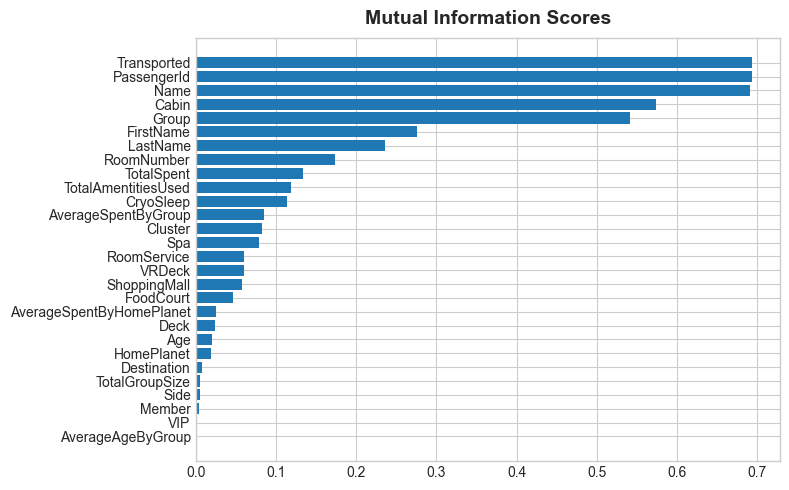

In [27]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [28]:
""" import plotly.express as px

sns.set(style="ticks", palette="viridis")

# Create a pairplot for each cluster
pairplot = sns.pairplot(feat_X, hue='Cluster', palette="viridis", plot_kws={'alpha':0.6}, diag_kind='hist', diag_kws={'alpha':0.6}) """

' import plotly.express as px\n\nsns.set(style="ticks", palette="viridis")\n\n# Create a pairplot for each cluster\npairplot = sns.pairplot(feat_X, hue=\'Cluster\', palette="viridis", plot_kws={\'alpha\':0.6}, diag_kind=\'hist\', diag_kws={\'alpha\':0.6}) '

## Train a model as a baseline

In [29]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#'Cabin', 'Group', 'FirstName', 'LastName', 'RoomNumber', 'TotalSpent', 'TotalAmentitiesUsed', 'CryoSleep', 'Cluster', 'Spa', 'RoomService', 'VRDeck'
train_columns = ['PassengerId', 'TotalSpent', 'Spa', 'RoomService', 'VRDeck', 'Member']

X_value = scaler.fit_transform(feat_X[train_columns])
y_value = feat_y

X_train, X_test, y_train, y_test = train_test_split(X_value, y_value, test_size=0.2, random_state=42)
                                                    
catboost_model = CatBoostClassifier(iterations=30, random_seed=42)
catboost_model.fit(X_train, y_train, verbose=False)


y_pred = catboost_model.predict(X_test)
y_pred = [True if label == 'True' else False for label in y_pred]

accuracy = accuracy_score(y_test, y_pred)
print(f"Base Catboost Accuracy :: {accuracy:.2f}")

Base Catboost Accuracy :: 0.81


## PCA Analysis

In [30]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_value)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.689543,0.429784,-1.749611,-0.221516,-0.047981,-0.057773
1,-0.221553,0.528576,-1.734162,-0.131774,0.238665,-0.143741
2,4.832646,0.264794,-2.071047,-0.069705,4.073637,-0.128160
3,2.145831,-0.263572,-1.899600,0.539742,1.824274,-0.148986
4,-0.101871,0.764492,-1.651115,0.038471,0.222285,-0.107079


In [31]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=train_columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
PassengerId,-0.003610,-0.201004,0.961386,-0.170849,0.078292,-0.001271
TotalSpent,0.677704,0.048253,0.017783,0.017972,-0.012117,0.733214
Spa,0.516186,-0.064833,-0.068698,0.010534,0.716446,-0.459592
RoomService,0.156141,0.743085,0.263253,0.529384,-0.165923,-0.215325
VRDeck,0.499348,-0.204681,-0.029544,-0.238697,-0.667917,-0.452543
Member,0.022998,-0.599163,0.022925,0.795709,-0.082374,-0.003247


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

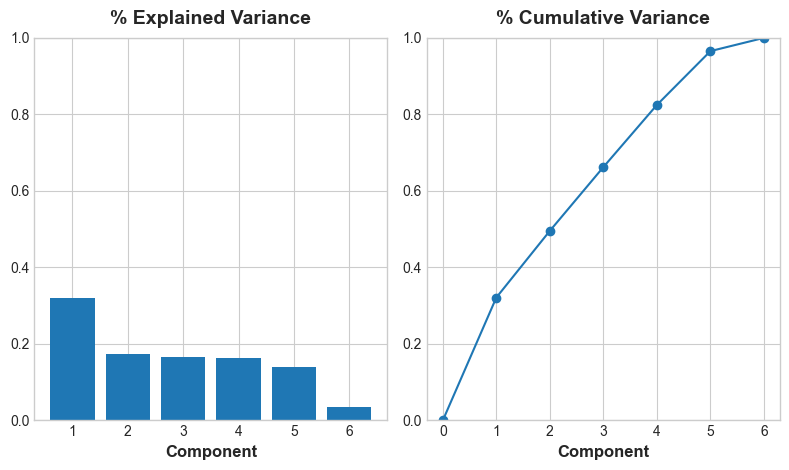

In [32]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


plot_variance(pca)

## Retrain

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_value, y_value, test_size=0.2, random_state=42)
                                                    
catboost_model = CatBoostClassifier(iterations=150, random_seed=42)
catboost_model.fit(X_train, y_train, verbose=False)


y_pred = catboost_model.predict(X_test)
y_pred = [True if label == 'True' else False for label in y_pred]

accuracy = accuracy_score(y_test, y_pred)
print(f"PCA Revised Catboost Accuracy :: {accuracy:.2f}")

PCA Revised Catboost Accuracy :: 0.81


## Imputing

In [81]:
from sklearn.metrics import mean_squared_error

df_impute = pd.read_csv('kaggle/input/spaceship-titanic/train.csv')

#impute missing values
df_impute[['Group', 'Member']] = df_impute['PassengerId'].str.split('_', expand=True)

condition = (df_impute['CryoSleep'] == True) & (df_impute[['RoomService', 'Spa', 'VRDeck']].isna().any(axis=1))
df_impute.loc[condition, ['RoomService', 'Spa', 'VRDeck']] = 0

df_impute[['Deck', 'RoomNumber', 'Side']] = df_impute['Cabin'].str.split('/', expand=True)

df_impute['TotalSpent'] = df_impute['RoomService'] + df_impute['Spa'] + df_impute['VRDeck']
df_impute['AverageSpentByHomePlanet'] = df_impute.groupby('HomePlanet')['TotalSpent'].transform('mean')
df_impute['AverageSpentByGroup'] = df_impute.groupby('Group')['TotalSpent'].transform('mean')
df_impute['TotalAmentitiesUsed'] = df_impute[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].gt(0).sum(axis=1)

df_impute['AverageAgeByGroup'] = df_impute.groupby('Group')['Age'].transform('mean')

feat_y = df_impute['Transported']

# Label encoding for categoricals
for colname in df_impute.select_dtypes("object"):
     df_impute[colname], _ = df_impute[colname].factorize()
    
discrete_features = df_impute.dtypes == int

train_columns = ['PassengerId', 'TotalSpent', 'Spa', 'RoomService', 'VRDeck', 'Member']

print(df_impute.head())
clean_rows = df_impute[train_columns].dropna()

print(df_impute.isna().sum())

rows_with_na = df_impute[train_columns]
rows_with_na = rows_with_na[rows_with_na.isna().any(axis=1)]

# loop over the training columns and impute mising values with catboost

for col in train_columns:
    
    if col != 'PassengerId':
        X = df_impute[train_columns]
        X = X.dropna()
        y = X.pop(col)

        print(X.head())
        
        X_test = df_impute[train_columns]
        X_test =  X_test[X_test.isna().any(axis=1)]
        y_test = X_test.pop(col)
        
        scaler = StandardScaler()

        X_scaled = scaler.fit_transform(X)
        y_scaled = y

        X_test_scaled = scaler.transform(X_test)
        y_test_scaled = y_test
        
        col_model = CatBoostRegressor(iterations=1000, learning_rate=0.01, depth=6, loss_function='RMSE', verbose=False)
        col_model.fit(X_scaled, y_scaled, plot=True)
        
        col_pred = col_model.predict(X_test_scaled)
        rows_with_na[col] = col_pred


imputed_data = pd.concat([clean_rows, rows_with_na])
print(imputed_data.isna().sum())
print(imputed_data.head(50))


   PassengerId  HomePlanet  CryoSleep  Cabin  Destination   Age  VIP  \
0            0           0          0      0            0  39.0    0   
1            1           1          0      1            0  24.0    0   
2            2           0          0      2            0  58.0    1   
3            3           0          0      2            0  33.0    0   
4            4           1          0      3            0  16.0    0   

   RoomService  FoodCourt  ShoppingMall  ...  Group  Member  Deck  RoomNumber  \
0          0.0        0.0           0.0  ...      0       0     0           0   
1        109.0        9.0          25.0  ...      1       0     1           0   
2         43.0     3576.0           0.0  ...      2       0     2           0   
3          0.0     1283.0         371.0  ...      2       1     2           0   
4        303.0       70.0         151.0  ...      3       0     1           1   

   Side  TotalSpent  AverageSpentByHomePlanet  AverageSpentByGroup  \
0     0   

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

   PassengerId  TotalSpent  RoomService  VRDeck  Member
0            0         0.0          0.0     0.0       0
1            1       702.0        109.0    44.0       0
2            2      6807.0         43.0    49.0       0
3            3      3522.0          0.0   193.0       1
4            4       870.0        303.0     2.0       0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

   PassengerId  TotalSpent     Spa  VRDeck  Member
0            0         0.0     0.0     0.0       0
1            1       702.0   549.0    44.0       0
2            2      6807.0  6715.0    49.0       0
3            3      3522.0  3329.0   193.0       1
4            4       870.0   565.0     2.0       0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

   PassengerId  TotalSpent     Spa  RoomService  Member
0            0         0.0     0.0          0.0       0
1            1       702.0   549.0        109.0       0
2            2      6807.0  6715.0         43.0       0
3            3      3522.0  3329.0          0.0       1
4            4       870.0   565.0        303.0       0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

   PassengerId  TotalSpent     Spa  RoomService  VRDeck
0            0         0.0     0.0          0.0     0.0
1            1       702.0   549.0        109.0    44.0
2            2      6807.0  6715.0         43.0    49.0
3            3      3522.0  3329.0          0.0   193.0
4            4       870.0   565.0        303.0     2.0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

PassengerId    0
TotalSpent     0
Spa            0
RoomService    0
VRDeck         0
Member         0
dtype: int64
    PassengerId  TotalSpent     Spa  RoomService  VRDeck  Member
0             0         0.0     0.0          0.0     0.0     0.0
1             1       702.0   549.0        109.0    44.0     0.0
2             2      6807.0  6715.0         43.0    49.0     0.0
3             3      3522.0  3329.0          0.0   193.0     1.0
4             4       870.0   565.0        303.0     2.0     0.0
5             5       291.0   291.0          0.0     0.0     0.0
6             6        42.0     0.0         42.0     0.0     0.0
7             7         0.0     0.0          0.0     0.0     1.0
8             8       216.0   216.0          0.0     0.0     0.0
9             9         0.0     0.0          0.0     0.0     0.0
10           10         0.0     0.0          0.0     0.0     1.0
11           11       273.0   110.0         39.0   124.0     2.0
12           12       186.0     0.0     

## Train on imputed data   

In [89]:
X_value = scaler.fit_transform(imputed_data)
y_value = feat_y

X_train, X_test, y_train, y_test = train_test_split(X_value, y_value, test_size=0.2, random_state=42)

catboost_model = CatBoostClassifier(random_seed=42)
catboost_model.fit(X_train, y_train, verbose=False)


y_pred = catboost_model.predict(X_test)
y_pred = [True if label == 'True' else False for label in y_pred]

accuracy = accuracy_score(y_test, y_pred)
print(f"PCA Revised Catboost Accuracy :: {accuracy:.2f}")

PCA Revised Catboost Accuracy :: 0.53


In [91]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X_value = scaler.fit_transform(imputed_data)
y_value = feat_y

X_train, X_test, y_train, y_test = train_test_split(X_value, y_value, test_size=0.2, random_state=42)

def objective(params):
    params = {
        'learning_rate': params['learning_rate'],
        'depth': int(params['depth']),
        'iterations': int(params['iterations']),
        'l2_leaf_reg': params['l2_leaf_reg']
    }
    
    catboost_model = CatBoostClassifier(**params, random_seed=42, verbose=False)
    catboost_model.fit(X_train, y_train)
    
    y_pred = catboost_model.predict(X_test)
    
    # Convert string labels in y_pred to boolean values
    y_pred_bool = [label == 'True' for label in y_pred]

    accuracy = accuracy_score(y_test, y_pred_bool)
    return {'loss': -accuracy, 'status': STATUS_OK}

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'depth': hp.quniform('depth', 4, 12, 1),
    'iterations': hp.quniform('iterations', 100, 1000, 50),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 9)
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

print(f"Best hyperparameters:\n{best}")


100%|██████████| 10/10 [00:18<00:00,  1.81s/trial, best loss: -0.5422656699252444]
Best hyperparameters:
{'depth': 9.0, 'iterations': 850.0, 'l2_leaf_reg': 3.3564958763960613, 'learning_rate': 0.037447442483517765}


In [92]:
catboost_model = CatBoostClassifier(**best, random_seed=42)
catboost_model.fit(X_train, y_train, verbose=False)


y_pred = catboost_model.predict(X_test)
y_pred = [True if label == 'True' else False for label in y_pred]

accuracy = accuracy_score(y_test, y_pred)
print(f"PCA Revised Catboost Accuracy :: {accuracy:.2f}")

PCA Revised Catboost Accuracy :: 0.54
